In [48]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import signal
import pprint
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import time
import seaborn as sns
import matplotlib.cm as cm
import statsmodels as sm
import pickle

In [49]:
def harmonic_mean(arr):
    arr = arr[::-1]
    n = len(arr)
    denominator = 0
    for i in range(1, n+1):
        denominator += 1/i
    numerator = 0
    for x, p in zip(arr, range(1, n+1)):
        numerator += x/p
    return numerator/denominator

In [50]:
weight_type = 'ons'
# weight_type = 'wider'

In [51]:
with open('data/GB/region_names/iso_names.txt', mode='r') as f:
    regions = f.read().splitlines()
    
name_to_omit = ['London, City of', 'Isles of Scily']

regions = [r.replace(' ', '_') for r in regions if r not in name_to_omit]
metrics = ['newCasesBySpecimenDate', 'newDeaths28DaysByDeathDate']

dfs = {}
for r in regions:
    for m in metrics:
        if m == metrics[0]:
            clinical = pd.read_csv('data/GB/regional/clinical/{}/{}.csv'.format(m, r), keep_default_na=False, na_values=[''])
            clinical = clinical.dropna(how='any').drop(['Unnamed: 0', 'areaType'], axis=1)
            clinical['date'] = pd.to_datetime(clinical['date'])
            clinical = clinical.set_index('date')
        else:
            try:
                tmp = pd.read_csv('data/GB/regional/clinical/{}/{}.csv'.format(m, r), keep_default_na=False, na_values=[''])
            except Exception as exc:
                break
            tmp['date'] = pd.to_datetime(tmp['date'])
            tmp = tmp.set_index('date')
#             clinical = pd.concat([clinical, tmp[m]], axis=1)
            clinical = pd.merge(clinical, tmp[m], left_index=True, right_index=True, how='outer')

    idx = clinical.columns.get_loc('nhsName')+1
    if list(clinical.columns.values[idx:]) != metrics:
        continue
    searches = pd.read_csv('data/GB/regional/searches/{}.csv'.format(r), keep_default_na=False, na_values=[''])
    searches = searches.drop(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_1_code', 'sub_region_2', 'sub_region_2_code', 'place_id'], axis=1)
    searches['date'] = pd.to_datetime(searches['date'])
    df = pd.merge(clinical, searches, on='date', how='outer').iloc[::-1].sort_values(by=['date'])
    df = df.set_index('date')
    dfs[r.replace('_', ' ')] = df
print(len(dfs))
# dfs['Aberdeen City']

189


In [52]:
for i, key in enumerate(dfs.keys()):
    dfs[key] = dfs[key].loc[:'2022-05-19']

In [53]:
columns = dfs['Aberdeen City'].columns[:dfs['Aberdeen City'].columns.get_loc('nhsName')+1].values
for key in dfs.keys():
    for c in columns:
        dfs[key][c] = dfs[key][c].fillna(dfs[key][c].iloc[500])

/var/folders/16/p0_pv93912d7zzx29sykqy800000gn/T/ipykernel_5180/2785928123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs[key][c] = dfs[key][c].fillna(dfs[key][c].iloc[500])


In [54]:
symptoms_ons =  ["Abdominal pain",  "Ageusia", "Anosmia", "Cough", "Diarrhea", "Fatigue", "Fever", "Headache", "Myalgia", "Nausea", 
                "Shortness of breath", "Sore throat", "Vomiting", "Weakness", ] 
symptoms_ff100 = ["Anosmia", "Arthralgia", "Clouding of consciousness", "Cough", "Diarrhea", "Fatigue", "Fever", "Headache", "Myalgia", 
            "Nausea", "Nosebleed", "Rhinitis", "Shortness of breath", "Skin rash", "Sore throat", "Vomiting",] 
symptoms_union = sorted(list(set(symptoms_ons) | set(symptoms_ff100)))
symptoms_wider = ["Abdominal pain", "Ageusia", "Anosmia", "Bronchitis", "Chills", "Cough", "Diarrhea", "Dizziness", "Dysgeusia", 
                  "Fatigue", "Fever", "Headache", "Hypoxia", "Laryngitis", "Low-grade fever", "Myalgia", "Nausea", "Pneumonia", "Rhinitis", 
                  "Shallow breathing", "Shortness of breath", "Sore throat", "Throat irritation", "Vertigo", "Vomiting", "Weakness", "Wheeze", ]
symptoms_wider= sorted(list(set(symptoms_wider) | set(symptoms_union)))

if weight_type == 'ons':
    symptoms = symptoms_ons
elif weight_type == 'wider':
    symptoms = symptoms_wider
symptoms = ['symptom:' + s for s in symptoms]

In [55]:
column = df.columns.get_loc(metrics[-1])+1
for key in dfs.keys():
    dfs[key] = pd.concat([dfs[key].iloc[:, :column], dfs[key][symptoms]], axis=1)
dfs['Aberdeen City']

,isoCode,areaCode,parentCode,isoName,googleName,nhsName,newCasesBySpecimenDate,newDeaths28DaysByDeathDate,symptom:Abdominal pain,symptom:Ageusia,...,symptom:Diarrhea,symptom:Fatigue,symptom:Fever,symptom:Headache,symptom:Myalgia,symptom:Nausea,symptom:Shortness of breath,symptom:Sore throat,symptom:Vomiting,symptom:Weakness
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,5.14,NaN,...,4.83,4.03,3.47,4.31,NaN,1.77,1.01,2.71,3.72,NaN
2019-01-02,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,5.02,NaN,...,3.80,5.82,3.37,3.77,NaN,2.11,0.77,3.00,3.31,0.95
2019-01-03,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,5.70,NaN,...,4.54,6.32,4.12,4.43,0.59,2.00,NaN,2.76,3.92,0.79
2019-01-04,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,4.42,NaN,...,4.31,6.21,4.14,4.51,NaN,2.30,0.78,3.71,3.65,NaN
2019-01-05,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,4.86,NaN,...,4.49,6.06,3.51,4.92,0.68,2.19,NaN,1.66,2.65,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-15,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,42.0,0.0,7.79,NaN,...,7.42,8.51,5.87,6.95,0.94,2.50,0.94,4.42,5.36,NaN
2022-05-16,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,57.0,0.0,7.90,NaN,...,7.87,8.75,4.83,5.16,0.62,3.06,1.33,3.33,5.25,NaN
2022-05-17,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,44.0,0.0,6.82,NaN,...,6.37,10.10,4.78,5.71,0.96,2.99,1.52,4.21,4.60,NaN


In [56]:
column = dfs['Aberdeen City'].columns.get_loc('newCasesBySpecimenDate')
for key in dfs.keys():
    dfs[key].iloc[:, column:]= dfs[key].iloc[:, column:].fillna(0)
dfs['Aberdeen City']

,isoCode,areaCode,parentCode,isoName,googleName,nhsName,newCasesBySpecimenDate,newDeaths28DaysByDeathDate,symptom:Abdominal pain,symptom:Ageusia,...,symptom:Diarrhea,symptom:Fatigue,symptom:Fever,symptom:Headache,symptom:Myalgia,symptom:Nausea,symptom:Shortness of breath,symptom:Sore throat,symptom:Vomiting,symptom:Weakness
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,5.14,0.0,...,4.83,4.03,3.47,4.31,0.00,1.77,1.01,2.71,3.72,0.00
2019-01-02,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,5.02,0.0,...,3.80,5.82,3.37,3.77,0.00,2.11,0.77,3.00,3.31,0.95
2019-01-03,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,5.70,0.0,...,4.54,6.32,4.12,4.43,0.59,2.00,0.00,2.76,3.92,0.79
2019-01-04,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,4.42,0.0,...,4.31,6.21,4.14,4.51,0.00,2.30,0.78,3.71,3.65,0.00
2019-01-05,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,4.86,0.0,...,4.49,6.06,3.51,4.92,0.68,2.19,0.00,1.66,2.65,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-15,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,42.0,0.0,7.79,0.0,...,7.42,8.51,5.87,6.95,0.94,2.50,0.94,4.42,5.36,0.00
2022-05-16,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,57.0,0.0,7.90,0.0,...,7.87,8.75,4.83,5.16,0.62,3.06,1.33,3.33,5.25,0.00
2022-05-17,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,44.0,0.0,6.82,0.0,...,6.37,10.10,4.78,5.71,0.96,2.99,1.52,4.21,4.60,0.00


In [57]:
column = dfs['Aberdeen City'].columns.get_loc(metrics[0])
index = dfs['Aberdeen City'].index
columns = dfs['Aberdeen City'].columns

for key in dfs.keys():
    dfs[key] = pd.concat([dfs[key].iloc[:, :column], pd.DataFrame(dfs[key].iloc[:, column:].rolling(7).mean(), index=index, columns=columns[column:])], axis=1)
dfs[key] = dfs[key].dropna(how='any')
dfs['Aberdeen City']

,isoCode,areaCode,parentCode,isoName,googleName,nhsName,newCasesBySpecimenDate,newDeaths28DaysByDeathDate,symptom:Abdominal pain,symptom:Ageusia,...,symptom:Diarrhea,symptom:Fatigue,symptom:Fever,symptom:Headache,symptom:Myalgia,symptom:Nausea,symptom:Shortness of breath,symptom:Sore throat,symptom:Vomiting,symptom:Weakness
date,,,,,,,,,,,,,,,,,,,,,
2019-01-07,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,5.032857,0.0,...,4.405714,6.040000,3.740000,4.367143,0.282857,2.087143,0.598571,2.817143,3.395714,0.248571
2019-01-08,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,4.951429,0.0,...,4.371429,6.455714,3.787143,4.254286,0.458571,2.097143,0.454286,2.852857,3.364286,0.350000
2019-01-09,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,4.951429,0.0,...,4.475714,6.430000,3.838571,4.311429,0.458571,2.050000,0.425714,2.807143,3.398571,0.214286
2019-01-10,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,4.690000,0.0,...,4.430000,6.361429,3.911429,4.321429,0.454286,2.021429,0.560000,2.770000,3.330000,0.101429
2019-01-11,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,4.797143,0.0,...,4.388571,6.242857,3.864286,4.288571,0.532857,1.988571,0.594286,2.585714,3.205714,0.101429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-15,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,43.714286,0.0,8.054286,0.0,...,7.001429,8.571429,5.445714,5.744286,0.614286,2.654286,1.241429,3.812857,4.872857,0.371429
2022-05-16,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,43.285714,0.0,8.068571,0.0,...,7.131429,8.430000,5.355714,5.832857,0.578571,2.691429,1.195714,3.760000,4.987143,0.251429
2022-05-17,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,43.142857,0.0,7.708571,0.0,...,7.061429,8.648571,5.348571,5.870000,0.622857,2.781429,1.185714,3.760000,5.004286,0.141429


In [58]:
news = pd.read_csv('data/GB/news_UK.csv')
news['date'] = pd.to_datetime(news['date'].astype(str))
news = news.set_index('date')
news = news.rename(columns={'covid-news-ratio-UK': 'news'})
for key in dfs.keys():
    dfs[key] = pd.merge(dfs[key], news, on='date')

In [59]:
df = None
for key in dfs.keys():
    df = pd.concat([df, dfs[key]], axis=0)

In [60]:
def adj_r2_score(y, y_pred, p):
    return 1-(1-r2_score(y, y_pred)) * (len(y)-1) / (len(y) - p - 1)

In [61]:
def normalisation(df, maximum=None, minimum=None, given=False):
    if given==False:
        maximum = df.max() + 1e-10
        minimum = df.min()
    return (df-minimum)/(maximum-minimum), maximum, minimum

def normalise_inverse(df, maximum, minimum):
    return df*(maximum-minimum)+minimum

In [62]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

def linear_regression(dfs, base_model='Linear', metric='newCasesBySpecimenDate', train_date=('2020-02-13', '2022-05-19'), test_date=None, 
                      shift=0, positive=False, alpha=10**np.arange(-6, -1, 0.1), l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=None):
        if base_model == 'Linear':
            model = LinearRegression(positive=positive)
        elif base_model == 'Lasso':
            model = LassoCV(alphas=alpha, cv=cv, max_iter=100000, positive=positive, random_state=random_state)
        elif base_model =='Ridge':
            model = RidgeCV(alphas=alpha, cv=cv)
        elif base_model == 'Elastic':
            model = ElasticNetCV(l1_ratio=l1_ratio, alphas=alpha, cv=cv, max_iter=100000, positive=positive, random_state=random_state)
        
        mm_y = MinMaxScaler()
        mm_x = MinMaxScaler()
        idx = df.columns.get_loc(metrics[-1])+1
        head =  sorted(set(df['isoName'].values))[0]
        tail = sorted(set(df['isoName'].values))[-1]
#         y_train = df[metric].shift(shift).loc[train_date[0]:train_date[1]].dropna()
        y_train = df[metric].shift(shift).dropna()
        y_train = pd.Series(mm_y.fit_transform(y_train.values.reshape(len(y_train),1)).flatten(), index=y_train.index)
#         x_train = df.iloc[:, idx:].loc[y_train.index[0]:y_train.index[-1]]
        x_train = df.iloc[shift:, idx:]
        x_train = pd.DataFrame(mm_x.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
        print(len(x_train))
        
        train_stats = {}
        model.fit(x_train, y_train)
        y_train_pred = pd.Series(model.predict(x_train), index=x_train.index)
        y_train_pred = y_train_pred.where(y_train_pred>=0, 0)
        train_stats['R^2'] = r2_score(y_train, y_train_pred)
        train_stats['Adj. R^2'] = adj_r2_score(y_train, y_train_pred, x_train.shape[1])
        train_stats['Correlation'] = np.corrcoef(y_train.values, y_train_pred.values)[0][1]
        y_train = pd.Series(mm_y.inverse_transform(y_train.values.reshape(len(y_train),1)).flatten(), index=y_train.index)
        y_train_pred = pd.Series(mm_y.inverse_transform(y_train_pred.values.reshape(len(y_train),1)).flatten(), index=y_train_pred.index)
        train_stats['RMSE:'] = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_stats['MAE'] = mean_absolute_error(y_train, y_train_pred)
        train_stats['MAPE'] = mean_absolute_percentage_error(y_train, y_train_pred)
        

        test_stats = {}
        y_test_pred = None
        if test_date is not None:
            y_test = df[metric].shift(shift).loc[test_date[0]:test_date[1]].dropna()
            y_test = pd.Series(mm_y.transform(y_test.values.reshape(len(y_train),1)).flatten(), index=y_test.index)
            x_test = df.iloc[:, idx:].loc[y_test.index[0]:y_test.index[-1]]
            x_test = pd.DataFrame(mm_x.transform(x_test), index=x_test.index, columns=x_test.columns)
            x_test = sm.add_constant(x_test, has_constant='add')
            y_test_pred =  pd.Series(model.predict(x_test), index=x_test.index)
            test_stats['R^2'] = r2_score(y_test, y_test_pred)
            test_stats['Adj. R^2'] = adj_r2_score(y_test, y_test_pred, x_test.shape[1])
            test_stats['Correlation'] = np.corrcoef(y_test.values, y_test_pred.values)[0][1]
            y_test = pd.Series(mm_y.inverse_transform(y_test.values.reshape(len(y_train),1)).flatten(), index=y_test.index)
            y_test_pred = pd.Series(mm_y.inverse_transform(y_test_pred.values.reshape(len(y_train),1)).flatten(), index=y_test_pred.index)
            test_stats['RMSE:'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_stats['MAE'] = mean_absolute_error(y_test, y_test_pred)
            test_stats['MAPE'] = mean_absolute_percentage_error(y_test, y_test_pred)
        
        coeffs = pd.DataFrame({base_model:np.append(model.intercept_, model.coef_.flatten())}, 
                              index=np.append('const', x_train.columns))
        return model, train_stats, test_stats,  y_train_pred, y_test_pred, coeffs

In [16]:
# metric = 'newCasesBySpecimenDate'
metric = 'newDeaths28DaysByDeathDate'
# model = 'Linear'
model = 'Elastic'
r = linear_regression(df, base_model=model, metric=metric, train_date=('2020-02-13', '2022-05-19'), test_date=None,
                      shift=0, positive=False, alpha=10**np.arange(-6, -3, 0.25), l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=10, random_state=1)
# plt.plot(r[3])
# plt.plot(df[metric])
print(r[1])
# print(r[0].alpha_, ':', r[0].l1_ratio_)
# r[5]

182007
{'R^2': 0.23547881698428053, 'Adj. R^2': 0.23541580388063676, 'Correlation': 0.49172384733048946, 'RMSE:': 1.8891589136470033, 'MAE': 0.8785445432710924, 'MAPE': 1007108005176619.0}


In [17]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

def linear_regression(df, base_model='Linear', metric='newCasesBySpecimenDate', train_date=('2020-02-13', '2022-05-19'), test_date=None, 
                      shift=0, positive=False, alpha=10**np.arange(-6, -1, 0.1), l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=None):
        if base_model == 'Linear':
            model = LinearRegression(positive=positive)
        elif base_model == 'Lasso':
            model = LassoCV(alphas=alpha, cv=cv, max_iter=100000, positive=positive, random_state=random_state)
        elif base_model =='Ridge':
            model = RidgeCV(alphas=alpha, cv=cv)
        elif base_model == 'Elastic':
            model = ElasticNetCV(l1_ratio=l1_ratio, alphas=alpha, cv=cv, max_iter=100000, positive=positive, random_state=random_state)
        
        mm_y = MinMaxScaler()
        mm_x = MinMaxScaler()
        idx = df.columns.get_loc(metrics[-1])+1
        y_train = df[metric].shift(shift).loc[train_date[0]:train_date[1]].dropna()
        y_train = pd.Series(mm_y.fit_transform(y_train.values.reshape(len(y_train),1)).flatten(), index=y_train.index)
        x_train = df.iloc[:, idx:].loc[y_train.index[0]:y_train.index[-1]]
        x_train = pd.DataFrame(mm_x.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
        
        train_stats = {}
        model.fit(x_train, y_train)
        y_train_pred = pd.Series(model.predict(x_train), index=x_train.index)
        y_train_pred = y_train_pred.where(y_train_pred>=0, 0)
        train_stats['R^2'] = r2_score(y_train, y_train_pred)
        train_stats['Adj. R^2'] = adj_r2_score(y_train, y_train_pred, x_train.shape[1])
        train_stats['Correlation'] = np.corrcoef(y_train.values, y_train_pred.values)[0][1]
        y_train = pd.Series(mm_y.inverse_transform(y_train.values.reshape(len(y_train),1)).flatten(), index=y_train.index)
        y_train_pred = pd.Series(mm_y.inverse_transform(y_train_pred.values.reshape(len(y_train),1)).flatten(), index=y_train_pred.index)
        train_stats['RMSE:'] = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_stats['MAE'] = mean_absolute_error(y_train, y_train_pred)
        train_stats['MAPE'] = mean_absolute_percentage_error(y_train, y_train_pred)
        
        
        test_stats = {}
        y_test_pred = None
        if test_date is not None:
            y_test = df[metric].shift(shift).loc[test_date[0]:test_date[1]].dropna()
            y_test = pd.Series(mm_y.transform(y_test.values.reshape(len(y_train),1)).flatten(), index=y_test.index)
            x_test = df.iloc[:, idx:].loc[y_test.index[0]:y_test.index[-1]]
            x_test = pd.DataFrame(mm_x.transform(x_test), index=x_test.index, columns=x_test.columns)
            x_test = sm.add_constant(x_test, has_constant='add')
            y_test_pred =  pd.Series(model.predict(x_test), index=x_test.index)
            test_stats['R^2'] = r2_score(y_test, y_test_pred)
            test_stats['Adj. R^2'] = adj_r2_score(y_test, y_test_pred, x_test.shape[1])
            test_stats['Correlation'] = np.corrcoef(y_test.values, y_test_pred.values)[0][1]
            y_test = pd.Series(mm_y.inverse_transform(y_test.values.reshape(len(y_train),1)).flatten(), index=y_test.index)
            y_test_pred = pd.Series(mm_y.inverse_transform(y_test_pred.values.reshape(len(y_train),1)).flatten(), index=y_test_pred.index)
            test_stats['RMSE:'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_stats['MAE'] = mean_absolute_error(y_test, y_test_pred)
            test_stats['MAPE'] = mean_absolute_percentage_error(y_test, y_test_pred)
        
        coeffs = pd.DataFrame({base_model:np.append(model.intercept_, model.coef_.flatten())}, 
                              index=np.append('const', x_train.columns))
        return model, train_stats, test_stats,  y_train_pred, y_test_pred, coeffs

{'R^2': 0.4328947128254389, 'Adj. R^2': 0.42240571244613134, 'Correlation': 0.6589471792054785, 'RMSE:': 1.67282540784138, 'MAE': 1.23194446314148, 'MAPE': 1923863000468375.8}


,Linear
const,-0.003753
symptom:Abdominal pain,0.246616
symptom:Ageusia,0.490373
symptom:Anosmia,-0.388042
symptom:Cough,-0.080124
symptom:Diarrhea,-0.171834
symptom:Fatigue,-0.531910
symptom:Fever,-0.911232
symptom:Headache,0.371582
symptom:Myalgia,-0.076687


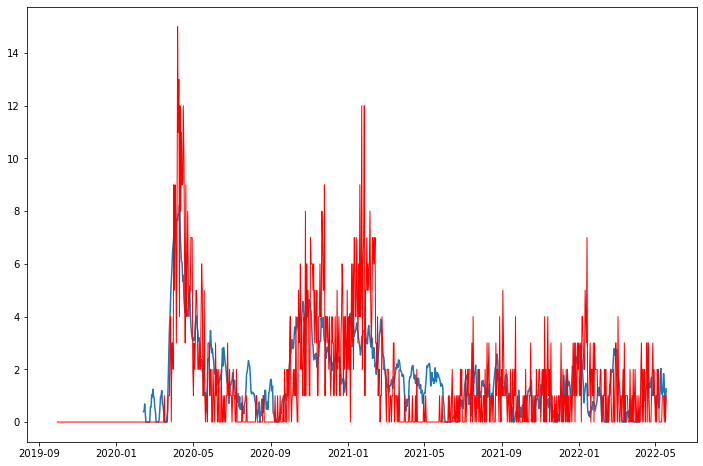

In [871]:
# metric = 'newCasesBySpecimenDate'
metric = 'newDeaths28DaysByDeathDate'
model = 'Linear'
# model = 'Elastic'
region = 'Manchester'
r = linear_regression(dfs[region], base_model=model, metric=metric, train_date=('2020-02-13', '2022-05-19'), test_date=None,
                      shift=0, positive=False, alpha=10**np.arange(-6, -3, 0.25), l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=10, random_state=1)
plt.figure(figsize=(12,8))
plt.plot(r[3])
plt.plot(dfs[region][metric], color='red', lw=1)
print(r[1])
# print(r[0].alpha_, ':', r[0].l1_ratio_)
r[5]
# r[3]

In [17]:
from statsmodels import api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

def forecasting_regression(dfs, base_model='Linear', metric='newCasesBySpecimenDate', date=('2020-02-13', '2022-05-19'), n=30, 
                           lag=7, period=0, positive=False, alpha=10**np.arange(-6, -2, 0.25), l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                           cv=3, random_state=None, auto=True, search=True, auto_lag=0):
    if base_model == 'Linear':
        model = LinearRegression(positive=positive)
    elif base_model == 'Lasso':
        model = LassoCV(alphas=alpha, cv=cv, max_iter=100000, positive=positive, random_state=random_state)
    elif base_model =='Ridge':
        model = RidgeCV(alphas=alpha, cv=cv)
    elif base_model == 'Elastic':
        model = ElasticNet(l1_ratio=0.1, alpha=0.01, max_iter=100000, positive=positive, random_state=random_state)

    idx = dfs['Aberdeen City'].columns.get_loc(metrics[-1])+1
#     y = pd.DataFrame(df[metric])
        
    y = None
    x = None
    for key in dfs.keys():
        x_tmp = pd.DataFrame(index=dfs[key].index, columns=[])
        if auto == True:
            for i in range(0, auto_lag+1):
                x_tmp = pd.concat([x_tmp, pd.DataFrame(dfs[key][metric].shift(i+lag).values, index=dfs[key].index, columns=[metric+('_ar_'+str(i))])], axis=1)
        if search==True:
            for i in range(0, auto_lag+1):
                x_tmp = pd.concat([x_tmp, pd.DataFrame(dfs[key].iloc[:,idx:].shift(i).values, index=dfs[key].index, columns=dfs[key].iloc[:,idx:].columns+('_lag_'+str(i)))], axis=1)
        x_tmp = x_tmp.dropna()
        x = pd.concat([x, x_tmp], axis=0)
        y = pd.concat([y, dfs[key][metric].loc[x_tmp.index[0]:x_tmp.index[-1]]], axis=0)
#         if auto == True:
#             x_tmp = pd.concat([dfs[key].iloc[:, idx:], dfs[key][metric].shift(lag)], axis=1).dropna()
#             x = pd.concat([x, x_tmp], axis=0)
#             y = pd.concat([y, dfs[key][metric].loc[x_tmp.index[0]:x_tmp.index[-1]]], axis=0)
#         else:
#             x = pd.concat([x, dfs[key].iloc[:, idx:]], axis=0)
#             y = pd.concat([y, dfs[key][metric]], axis=0)
    y = pd.DataFrame(y.sort_index())
    x = x.sort_index()
    
#     if auto == True:
#         x = pd.concat([x, y.shift(lag)], axis=1).dropna()
#         y = y.loc[x.index[0]:x.index[-1]]
        
    errors = {}
    predictions = {}
#     coeffs = pd.DataFrame(index=x.columns, columns=[])
    num = len(set(dfs.keys()))
    date_range = len(set(y.index))
    for i in range(date_range-lag-period-n):
        mm_y = MinMaxScaler()
        mm_x = MinMaxScaler()
        y_train = mm_y.fit_transform(y.iloc[((period+i)*num):((period+i+n)*num)])
        y_train = pd.DataFrame(y_train, index=y.index[((period+i)*num):((period+i+n)*num)], columns=[metric])
        x_train = pd.DataFrame(mm_x.fit_transform(x.iloc[(i*num):((i+n)*num), :]), index=x.index[(i*num):((i+n)*num)], columns=x.columns)
        if y.index[(lag+period+i+n)*num] <= y.index[-1]+datetime.timedelta(days=lag):
            y_test = mm_y.transform(y.iloc[((lag+period+i+n)*num):((lag+period+i+n+1)*num)])
            y_test = pd.DataFrame(y_test, index=y.index[((lag+period+i+n)*num):((lag+period+i+n+1)*num)], columns=[metric])
        x_test = x.iloc[((lag+i+n)*num):((lag+i+n+1)*num), :]
        x_test = pd.DataFrame(mm_x.transform(x_test), index=x.index[((lag+i+n)*num):((lag+i+n+1)*num)], columns=x.columns)
    
        model.fit(x_train, y_train)
        pred_date = y.index[(lag+period+i+n)*num]

#         coeffs = pd.concat([coeffs, pd.DataFrame(np.append(model.intercept_, model.coef_.reshape(-1,1)), index=np.append('const', x.columns), columns=[pred_date])], axis=1)
        pred = model.predict(x_test)
        pred = mm_y.inverse_transform(pred.reshape(len(pred),1))
        pred = np.array([p if p[0]>=0.0 else [0.0] for p in pred])
        predictions[pred_date] = pred.flatten()
        if y.index[(lag+period+i+n)*num] <= y.index[-1]+datetime.timedelta(days=lag):
            y_test = mm_y.inverse_transform(y_test)
            errors[pred_date] = abs(y_test - pred).flatten()
    return predictions, errors

In [66]:
df = None
for key in dfs.keys():
    df = pd.concat([df, dfs[key]], axis=0)
df = df.sort_index()

In [198]:
metric = 'newDeaths28DaysByDeathDate'
# model = 'Linear'
model = 'Elastic'

n= 10
period = 14
lag = 7
auto = True
search = True
auto_lag = 2

r2 = forecasting_regression(dfs, base_model=model, metric=metric,
                            n=n, lag=lag, period=period , auto=auto, search=search, auto_lag=auto_lag)
# plt.figure(figsize=(12,8))
# plt.plot(r[3])
# plt.plot(dfs[region][metric], color='red', lw=1)
# print(round(error.loc[date[0]:date[1]].mean(), 1))
# print(round(error.loc[date[0]:date[1]].std(), 1))

/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/asai/miniforge3/envs/dsml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

In [199]:
test_date=('2021-05-20', '2022-05-19')

e = pd.DataFrame(r2[1].values(), index=r2[1].keys(), columns=dfs.keys()).loc[test_date[0]:test_date[1]]
print(np.round(e.mean().mean(),3))
print(np.round(e.std().mean(),3))

p = pd.DataFrame(r2[0].values(), index=r2[0].keys(), columns=dfs.keys()).T
c = {}
for key, row in zip(p.index, p.loc[:, test_date[0]:test_date[1]].iterrows()):
    c[key] = np.corrcoef(dfs[key][metric].loc[test_date[0]:test_date[1]].values, row[1].values)[0][1]
np.round(np.mean(list(c.values())),3)

0.494
0.596


0.535

In [200]:
date = ['2021-11-20', '2022-05-19']
metric = 'newCasesBySpecimenDate'
# metric = 'newDeaths28DaysByDeathDate'
# metric = 'newAdmissions'
shift = 7

errors = {}
correl = {}
for key in dfs.keys():
    df_shift = dfs[key][metric].shift(shift).loc[date[0]:date[1]].dropna()
    df_copy = dfs[key][metric].loc[df_shift.index[0]:df_shift.index[-1]]
    errors[key] = abs(df_copy - df_shift)
    correl[key] = np.corrcoef(df_copy.values, df_shift.values)[0][1]

In [201]:
print(np.round(pd.DataFrame(errors.values(), index=errors.keys()).mean().mean(),3))
print(np.round(pd.DataFrame(errors.values(), index=errors.keys()).std().mean(),3))
print(np.round(pd.DataFrame(correl.values(), index=errors.keys()).mean(),3))

97.81
94.847
0    0.817
dtype: float64
